In [63]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

In [64]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 93us/step - loss: 0.3671 - categorical_accuracy: 0.2340 - val_loss: 0.2814 - val_categorical_accuracy: 0.5305
Epoch 2/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.2261 - categorical_accuracy: 0.7041 - val_loss: 0.1779 - val_categorical_accuracy: 0.8011
Epoch 3/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.1472 - categorical_accuracy: 0.8314 - val_loss: 0.1260 - val_categorical_accuracy: 0.8373
Epoch 4/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.1085 - categorical_accuracy: 0.8596 - val_loss: 0.1001 - val_categorical_accuracy: 0.8528
Epoch 5/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.0869 - categorical_accuracy: 0.8749 - val_loss: 0.0845 - val_categorical_accuracy: 0.8683
Epoch 6/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.0731 - categor

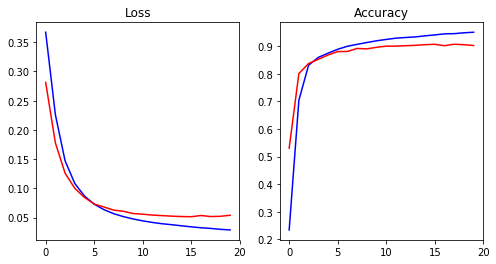

In [42]:
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K
from model import GaussMembership, normalized_product_fn


def train_hybrid():
    model = keras.Sequential([
        layers.Reshape((28,28,1), input_shape=(28,28)),
        layers.Conv2D(16, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(32, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(64, (3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Flatten(),
        GaussMembership(10),
        layers.Lambda(lambda x: normalized_product_fn(x)),
        layers.Dense(10, activation="sigmoid"),
    ])
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=20,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True)
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")
    axes[0].plot(history.history["val_loss"], c="r")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")
    axes[1].plot(history.history["val_categorical_accuracy"], c="r")

    return model


hybrid_model = train_hybrid()

5


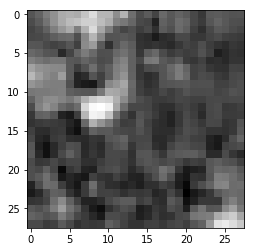

In [159]:
from scipy.ndimage.filters import gaussian_filter

image = np.copy(train_x[0,:,:].reshape(1,28,28))

target = np.zeros((1,10))
target[:,5] = 1

output = hybrid_model.output[:,0]

# loss and gradients
loss = -K.sum(target * K.log(output) + (1 - target) * K.log(1 - output))
grads = K.gradients(loss, hybrid_model.inputs)
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-8)

iterate = K.function(hybrid_model.inputs, [loss, grads])

for i in range(20):
    loss_val, grads_val = iterate([image])
    image -= grads_val.reshape(1,28,28)
    image = gaussian_filter(image, 0.5)
    
fstrength = K.function(hybrid_model.inputs, [hybrid_model.layers[6].output])
print(np.argmax(hybrid_model.predict(image)))

plt.imshow(image.reshape(28,28), cmap="Greys")